# Introdução a Classificadores

Nesse laboratório iremos estudar o uso de classificadores

### <font color='red'>Antes de dar continuidade no laboratório certifique-se que o scikit-learn está instalado em seu ambiente </font>

In [56]:
#para verificar tente importar o pacote
import sklearn
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

## Descrição do dataset

Para esse laboratório, iremos utilizar uma base de dados de logs de um firewall. O firewall é responsável por gerenciar o fluxo de conexões de entrada e de saída de uma rede, permitindo, negando, cancelando, e resetando conexões. No dataset há um total de 12 características, representadas por:
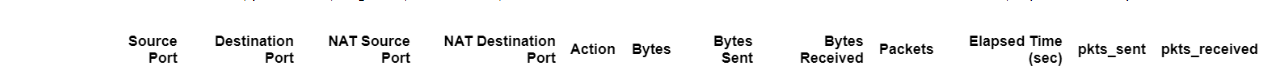

A característica **Action** determina a classe de cada conexão. Nesse cenário, 4 classes são possíveis, representando as ações do *firewall*, assim, as seguintes classes estão disponíveis:

* Allow
* Deny
* Drop
* Reset

O objetivo desse laboratório é treinar um classificador para aprender os padrões das ações do firewall considerando as características disponíveis (excluindo a característica **Action**). A Figura abaixo representa o *workflow* do classificador que será implementado



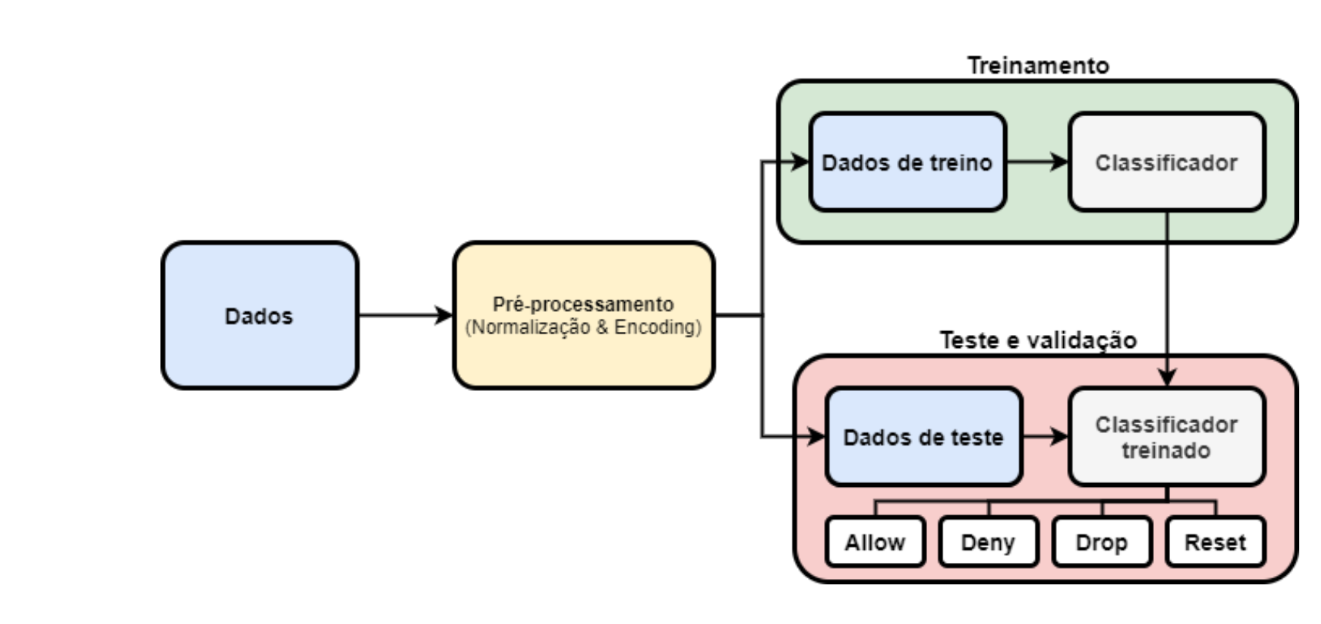

Para realizar a implementação e treinamento do classificador, os seguintes passos serão seguidos:

* 1. Obtenção de dados
* 2. Pré-processamento
* 3. Separação de dados de treino e teste
* 4. Treinamento
* 5. Testes e avaliações
* 6. Aprimorando resultados

## 1. Obtenção e análise inicial dos dados

In [46]:
import pandas as pd

df   = pd.read_csv('firewall_log.csv')
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53.0,54587.0,53.0,allow,177.0,94.0,83,2.0,30.0,1,1
1,56258,3389.0,56258.0,3389.0,allow,4768.0,1600.0,3168,19.0,17.0,10,9
2,6881,50321.0,43265.0,50321.0,allow,238.0,118.0,120,2.0,1199.0,1,1
3,50553,3389.0,50553.0,3389.0,allow,3327.0,1438.0,1889,15.0,17.0,8,7
4,50002,443.0,45848.0,443.0,NaN,25358.0,6778.0,18580,31.0,16.0,13,18


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Source Port           65532 non-null  int64  
 1   Destination Port      65521 non-null  float64
 2   NAT Source Port       65524 non-null  float64
 3   NAT Destination Port  65530 non-null  float64
 4   Action                65523 non-null  object 
 5   Bytes                 65527 non-null  float64
 6   Bytes Sent            65531 non-null  float64
 7   Bytes Received        65532 non-null  int64  
 8   Packets               65530 non-null  float64
 9   Elapsed Time (sec)    65530 non-null  float64
 10  pkts_sent             65532 non-null  int64  
 11  pkts_received         65532 non-null  int64  
dtypes: float64(7), int64(4), object(1)
memory usage: 6.0+ MB


<Axes: >

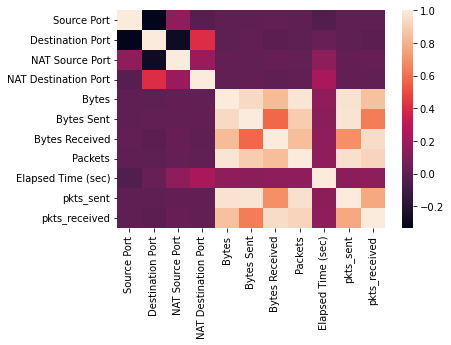

In [82]:
sns.heatmap(df.corr())

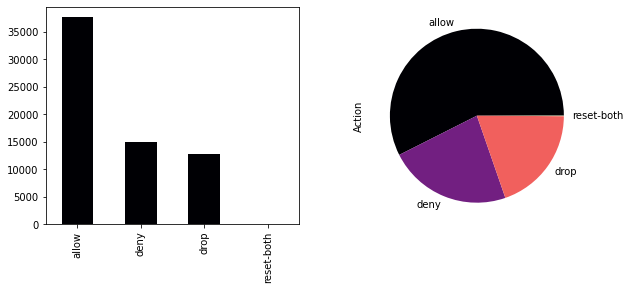

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax      = ax.flatten()
freq    = df['Action'].value_counts()

freq.plot.bar(cmap='magma', ax=ax[0]);
freq.plot.pie(cmap='magma', ax=ax[1]);

In [5]:
df['Action'].value_counts()

allow         37636
deny          14985
drop          12848
reset-both       54
Name: Action, dtype: int64

In [6]:
def balancear_dataset(df):
    df_balanceado = pd.DataFrame()
    for classe in df['Action'].unique():
        df_filtrado_por_classe = df[df['Action'] == classe].copy()

        if len(df_filtrado_por_classe) > 12_000:
            df_filtrado_por_classe = df_filtrado_por_classe.sample(n=12_000, )

        df_balanceado = pd.concat([df_balanceado, df_filtrado_por_classe])
        
    return df_balanceado.sample(frac=1)

In [7]:
df = balancear_dataset(df)
df['Action'].value_counts()

allow         12000
drop          12000
deny          12000
reset-both       54
Name: Action, dtype: int64

## 1.1 Verificando dados nulos

In [8]:
df.isnull().sum()

Source Port             0
Destination Port        8
NAT Source Port         3
NAT Destination Port    1
Action                  0
Bytes                   2
Bytes Sent              0
Bytes Received          0
Packets                 2
Elapsed Time (sec)      1
pkts_sent               0
pkts_received           0
dtype: int64

## 1.2 Removendo dados nulos

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

## 2. Eastruturação dos dados

### 2.1 Separação de dados e classes (X e Y)

A ideia da estruturação dos dados e classes é separar os dados que serão usados como entrada para o algoritmo (ou seja, X) e as classes que são esperadas na saída (ou seja, Y). Portanto, essa separação pode ser representada conforme a figura abaixo

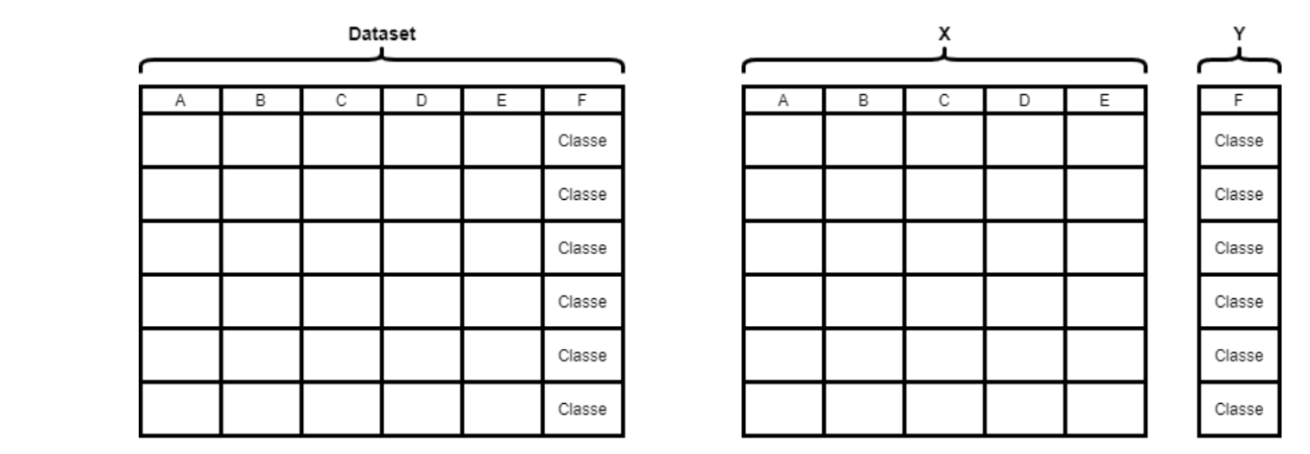

In [11]:
Y = df['Action'].values

df.drop('Action', axis=1, inplace=True)

X = df.values

In [12]:
print(X, len(X))

[[4.9872e+04 5.3000e+01 4.9872e+04 ... 2.9000e+01 1.0000e+00 1.0000e+00]
 [5.2496e+04 4.4500e+02 0.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [6.0830e+04 5.0584e+04 0.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [5.3362e+04 2.3000e+01 0.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [5.5657e+04 5.3000e+01 5.6154e+04 ... 3.4000e+01 2.0000e+00 0.0000e+00]
 [5.4310e+03 5.3000e+01 5.4310e+03 ... 3.1000e+01 1.0000e+00 1.0000e+00]] 36037


In [13]:
print(Y, len(Y))

['allow' 'drop' 'deny' ... 'deny' 'allow' 'allow'] 36037


## 3. Pré-processamento

### 3.1 Encoding
o enconding é utilizado para transformar valroes não numéricos em valores numéricos para que os algoritmos de machine learning possam aplicar as operações nesses dados para explorar e identificar padrões

In [14]:
print(f'Dados sem enconding: {Y}')

Dados sem enconding: ['allow' 'drop' 'deny' ... 'deny' 'allow' 'allow']


In [15]:
from sklearn import preprocessing

le      = preprocessing.LabelEncoder()

le.fit(Y)
#verifica classes
le.classes_

Y_encoded = le.transform(Y)

print(f'Dados com enconding: {Y_encoded}')

Dados com enconding: [0 2 1 ... 1 0 0]


### 3.2 Normalização

A normalização é aplicada para reduzir a distribuição dos dados, pois para os algoritmos de machine learning são mais eficiêntes em explorar e identificar padrões com distribuições entre -1 e 1

In [16]:
X

array([[4.9872e+04, 5.3000e+01, 4.9872e+04, ..., 2.9000e+01, 1.0000e+00,
        1.0000e+00],
       [5.2496e+04, 4.4500e+02, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.0830e+04, 5.0584e+04, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [5.3362e+04, 2.3000e+01, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [5.5657e+04, 5.3000e+01, 5.6154e+04, ..., 3.4000e+01, 2.0000e+00,
        0.0000e+00],
       [5.4310e+03, 5.3000e+01, 5.4310e+03, ..., 3.1000e+01, 1.0000e+00,
        1.0000e+00]])

In [17]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
56504,49872,53.0,49872.0,53.0,218.0,90.0,128,2.0,29.0,1,1
55926,52496,445.0,0.0,0.0,70.0,70.0,0,1.0,0.0,1,0
6449,60830,50584.0,0.0,0.0,62.0,62.0,0,1.0,0.0,1,0
22385,62132,445.0,0.0,0.0,66.0,66.0,0,1.0,0.0,1,0
22871,39661,53733.0,0.0,0.0,146.0,146.0,0,1.0,0.0,1,0


In [18]:
from sklearn import preprocessing

colunas            = df.columns
norm               = preprocessing.Normalizer()
dados_normalizados = norm.transform(X)
df_norm            = pd.DataFrame(dados_normalizados, columns=colunas)
X                  = dados_normalizados

df_norm.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0.707101,0.000751,0.707101,0.000751,0.003091,0.001276,0.001815,0.000028,0.000411,0.000014,0.000014
1,0.999962,0.008477,0.000000,0.000000,0.001333,0.001333,0.000000,0.000019,0.000000,0.000019,0.000000
2,0.768890,0.639381,0.000000,0.000000,0.000784,0.000784,0.000000,0.000013,0.000000,0.000013,0.000000
3,0.999973,0.007162,0.000000,0.000000,0.001062,0.001062,0.000000,0.000016,0.000000,0.000016,0.000000
4,0.593858,0.804564,0.000000,0.000000,0.002186,0.002186,0.000000,0.000015,0.000000,0.000015,0.000000


## 4. Separação de treiono e teste

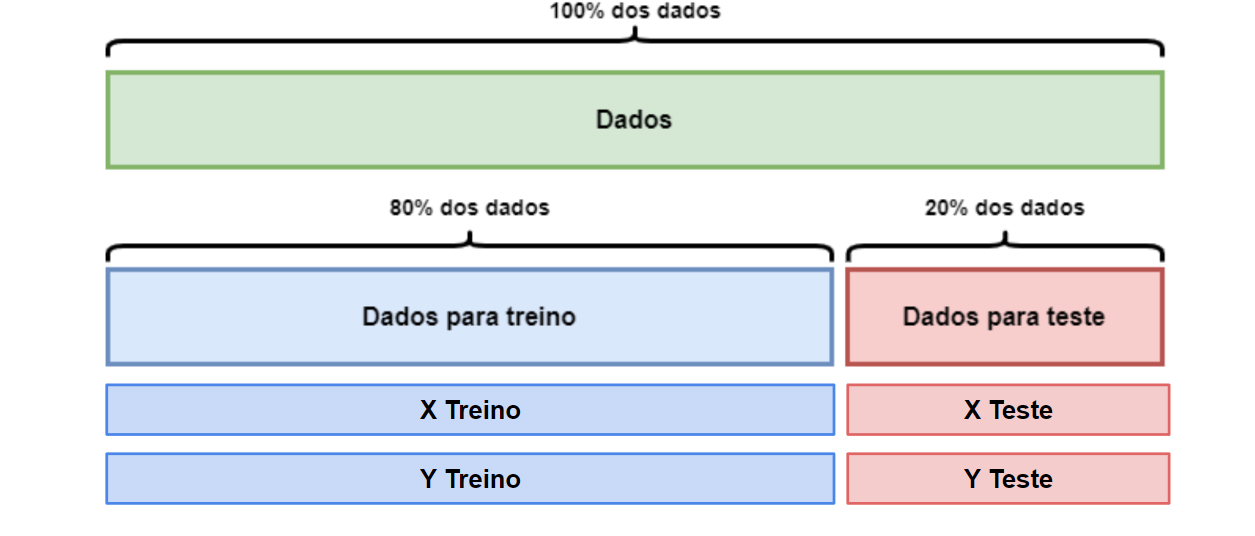

In [19]:
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size=0.2, random_state=99)

In [20]:
print(f'Quantidade de dados para treino X: {len(x_treino)} e Y: {len(y_treino)}')
print(f'Quantidade de dados para teste X: {len(x_teste)} e Y: {len(y_teste)}')

Quantidade de dados para treino X: 28829 e Y: 28829
Quantidade de dados para teste X: 7208 e Y: 7208


## 5. Treinamento

A fase de treinamento consiste em mostrar para o classificador a classe de cada sequencia de características. Por exemplo, a sequencia de características x_treino[10] é definida pela classe y_treino[10]

### 5.1 KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x_treino, y_treino)
knn.score(x_treino, y_treino)

0.9957334628325645

## 6. Testes e avaliação

A fase de teste consiste em avaliar o classificador, ou seja, para cada sequência de característica o classificador irá devolver como resultado uma classe. Assim, baseado em uma sequencia de características ainda não vista pelo classificador (x_teste) é possível comparar a saída (classe) dada pelo classificador para compara-lá com a saída esperada (y_teste)


### 6.1 Realizando predições

### 6.1.1 Predição simples

In [22]:
print('...Exemplo input...')
print(x_teste[0])
print(x_teste[100])
print(x_teste[200])
# pred_knn = knn.predict(x_teste)

print('\n\n...Exemplo Classificação...')
print(f'input x_teste[0] -> classificação KNN: {knn.predict([x_teste[0]])}, classificação real: {y_teste[0]} ')
print(f'input x_teste[100] -> classificação KNN: {knn.predict([x_teste[100]])}, classificação real: {y_teste[100]} ')
print(f'input x_teste[300] -> classificação KNN: {knn.predict([x_teste[200]])}, classificação real: {y_teste[200]} ')

...Exemplo input...
[5.10363422e-01 5.67135565e-01 3.09430858e-01 5.67135565e-01
 1.68010769e-02 2.38125500e-03 1.44198219e-02 3.77976984e-05
 5.85864325e-04 1.88988492e-05 1.88988492e-05]
[9.69476297e-01 7.05287877e-03 2.34448516e-01 7.05287877e-03
 5.58339635e-02 1.43286476e-02 4.15053159e-02 2.06969354e-04
 2.14929714e-03 9.55243174e-05 1.11445037e-04]
[7.05880055e-01 2.82629319e-03 7.05880055e-01 2.82629319e-03
 4.38875339e-02 5.22597608e-03 3.86615578e-02 1.06652573e-04
 1.59978860e-03 5.33262866e-05 5.33262866e-05]


...Exemplo Classificação...
input x_teste[0] -> classificação KNN: ['allow'], classificação real: allow 
input x_teste[100] -> classificação KNN: ['allow'], classificação real: allow 
input x_teste[300] -> classificação KNN: ['allow'], classificação real: allow 


### 6.1.2 Predição de multiplos dados

In [23]:
pred_knn = knn.predict(x_teste)

print('Exemplo comparação')
print(f'Classificação KNN: {pred_knn[0]} Classificação real: {y_teste[0]}')
print(f'Classificação KNN: {pred_knn[100]} Classificação real: {y_teste[100]}')
print(f'Classificação KNN: {pred_knn[200]} Classificação real: {y_teste[200]}')

Exemplo comparação
Classificação KNN: allow Classificação real: allow
Classificação KNN: allow Classificação real: allow
Classificação KNN: allow Classificação real: allow


### 6.2 Métricas de avaliação

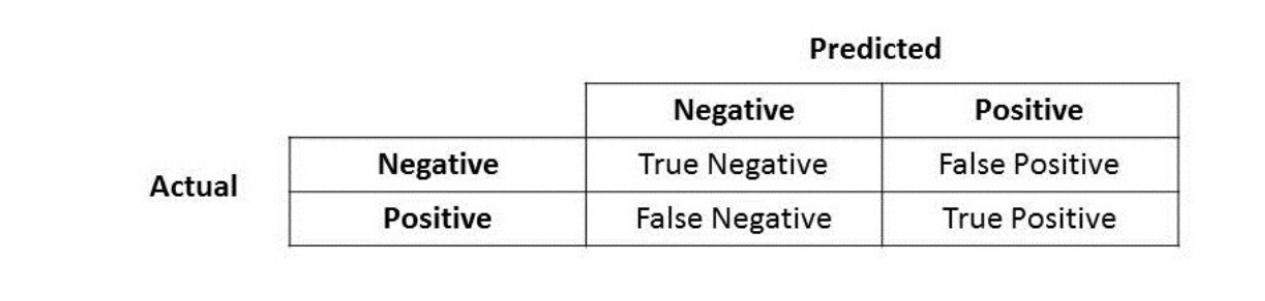

### 6.2.1 Accuracy

In [24]:
from sklearn.metrics import accuracy_score

accuracy_knn = accuracy_score(y_teste, pred_knn)
accuracy_knn

0.9962541620421753

### 6.2.2 Precision

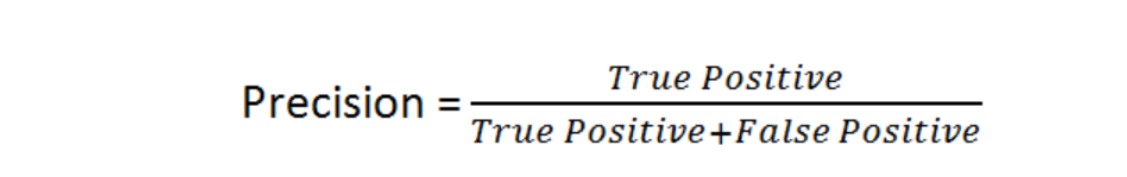

In [25]:
from sklearn.metrics import precision_score

precision_knn = precision_score(y_teste, pred_knn, average='micro')
precision_knn

0.9962541620421753

### 6.2.3 Recall
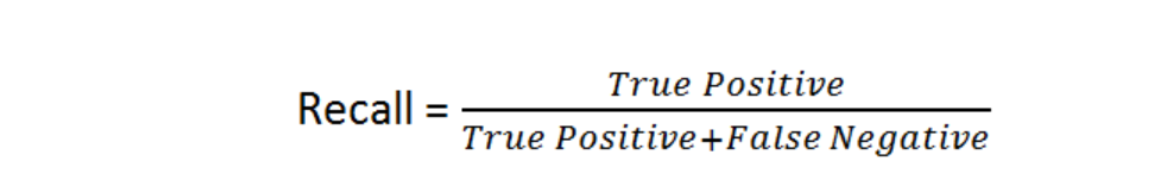

In [26]:
from sklearn.metrics import recall_score

recall_knn = recall_score(y_teste, pred_knn, average='micro')
recall_knn

0.9962541620421753

### 6.3 Relatório de classificação

In [27]:
from sklearn.metrics import classification_report

# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_teste, pred_knn, zero_division=0))  

Relatório de classificação: 
               precision    recall  f1-score   support

       allow       1.00      1.00      1.00      2371
        deny       1.00      0.99      0.99      2425
        drop       1.00      1.00      1.00      2404
  reset-both       0.00      0.00      0.00         8

    accuracy                           1.00      7208
   macro avg       0.75      0.75      0.75      7208
weighted avg       1.00      1.00      1.00      7208



### 6.4 Matriz de confusão

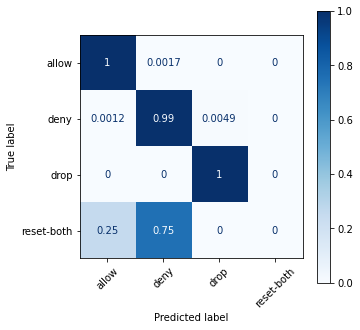

In [28]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
disp = plot_confusion_matrix(knn, x_teste, y_teste, xticks_rotation=45, normalize='true', cmap=plt.cm.Blues, ax=ax)

## 7. Aprimorando resultados

### 7.2 Cross-validation e Hyperparametros

### 7.2.1 K-Fold

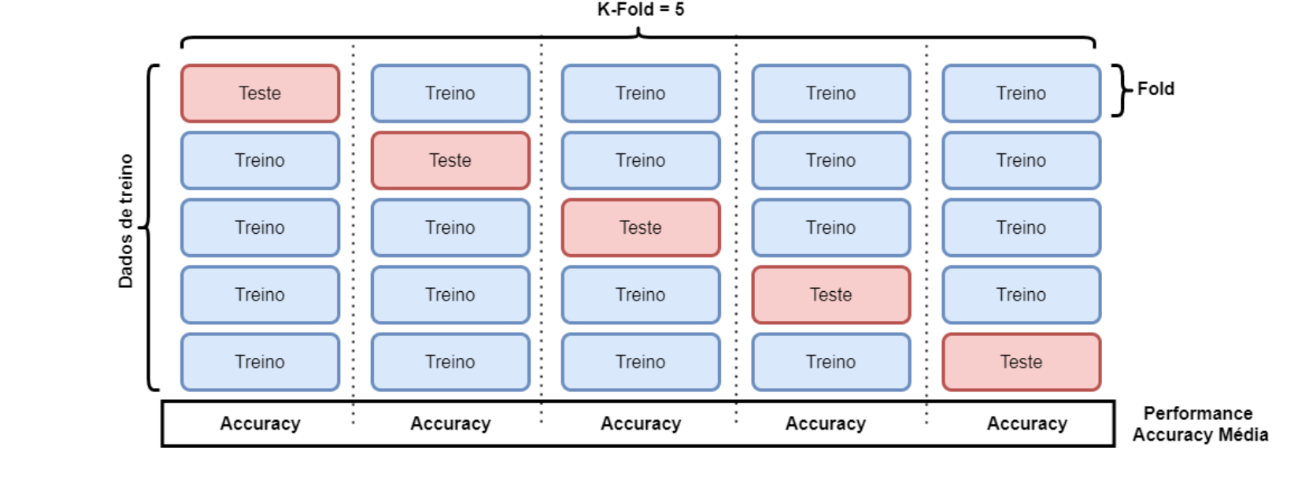

### 7.2.2 Avaliando hyperparamêtros
A avaliação de hyperparâmetros testa qual o melhor valor do hyperparâmetro para o conjunto de dados utilizados. Valores com maior accuracy durante o treino, potêncialmente tem o melhor desempenho na fase de teste também

In [29]:
from sklearn.model_selection import cross_val_score

accuracy_list = []
Ks = ( 3, 7, 11, 25, 51, 115, 223, 301)

for k in Ks:
    knn    = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_treino, y_treino, cv=5)
    accuracy_list.append(scores.mean())
    

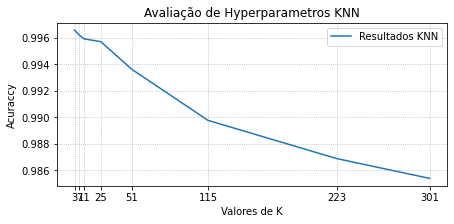

In [30]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(Ks, accuracy_list, label='Resultados KNN')
ax.grid(True, linestyle=':')
ax.set(xlabel='Valores de K', ylabel='Acuraccy', title='Avaliação de Hyperparametros KNN', xticks=Ks);
plt.legend()
plt.show();

Para a análise anterior vimos que o valor de 3

## 8. Comparando desempenho entre classificadores

### 8.1 KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_treino, y_treino)

KNeighborsClassifier(n_neighbors=3)

### 8.2 SVM

In [32]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(x_treino, y_treino)

SVC(kernel='linear')

### 8.3 Árvore de Decisão

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=3)

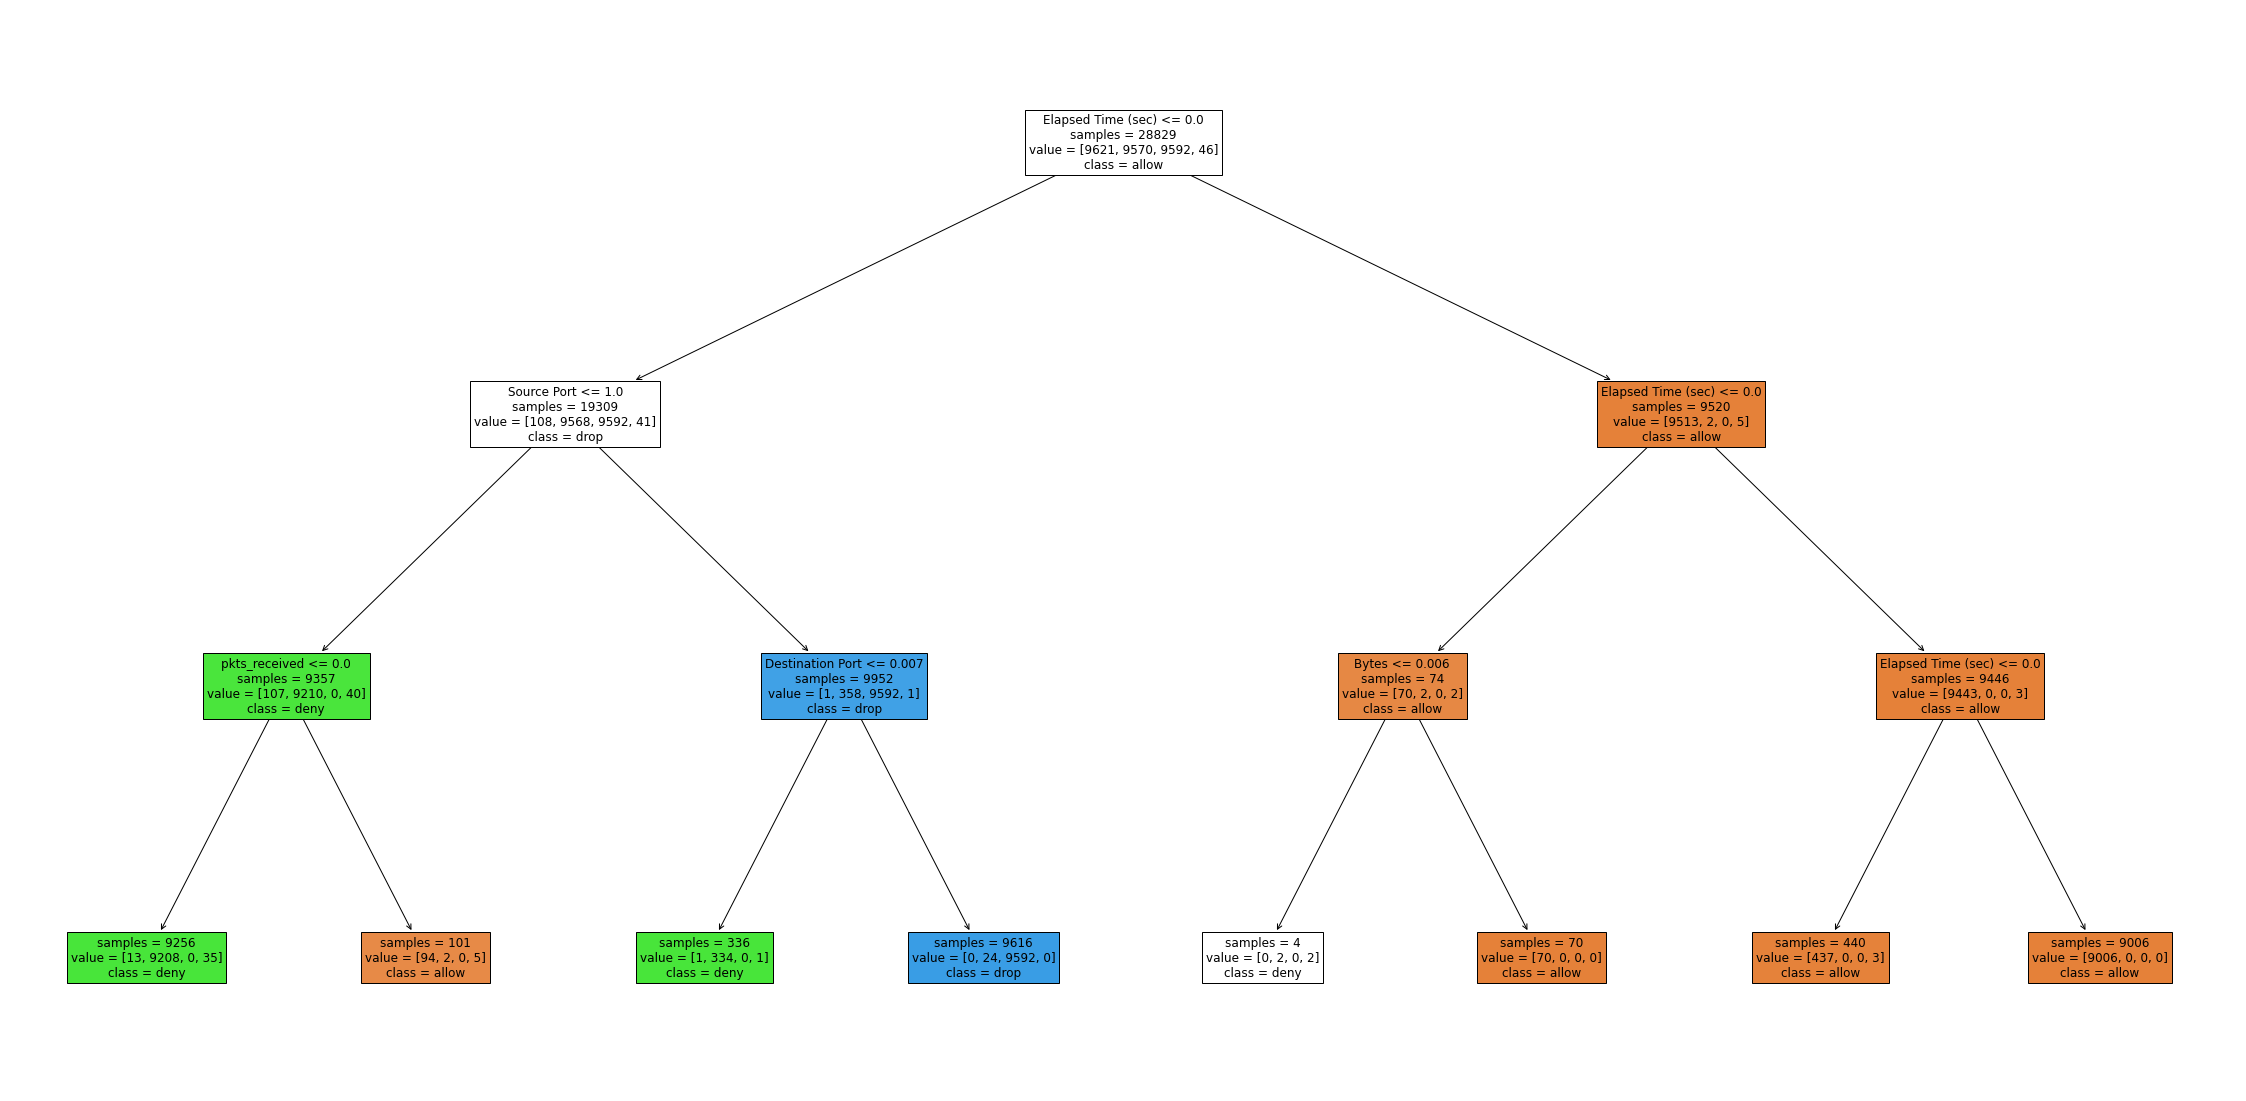

In [34]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

#Mostrar Caracteristicas e Classes para melhorar a visualização
classes         = list(np.unique(y_treino))
caracteristicas = list(df.columns)

plt.figure(figsize=(40,20))
plot_tree(dt, feature_names=caracteristicas, class_names=classes, filled=True, impurity=False, fontsize=12);


In [35]:
from sklearn.tree import export_text

caracteristicas = list(df.columns)

text = export_text(dt, feature_names=caracteristicas, )
print(text)

|--- Elapsed Time (sec) <= 0.00
|   |--- Source Port <= 1.00
|   |   |--- pkts_received <= 0.00
|   |   |   |--- class: deny
|   |   |--- pkts_received >  0.00
|   |   |   |--- class: allow
|   |--- Source Port >  1.00
|   |   |--- Destination Port <= 0.01
|   |   |   |--- class: deny
|   |   |--- Destination Port >  0.01
|   |   |   |--- class: drop
|--- Elapsed Time (sec) >  0.00
|   |--- Elapsed Time (sec) <= 0.00
|   |   |--- Bytes <= 0.01
|   |   |   |--- class: deny
|   |   |--- Bytes >  0.01
|   |   |   |--- class: allow
|   |--- Elapsed Time (sec) >  0.00
|   |   |--- Elapsed Time (sec) <= 0.00
|   |   |   |--- class: allow
|   |   |--- Elapsed Time (sec) >  0.00
|   |   |   |--- class: allow



### 8.4 Comparando métricas

In [36]:
from sklearn.metrics import accuracy_score

pred_svm = svm.predict(x_teste)
pred_knn = knn.predict(x_teste)
pred_dt  = dt.predict(x_teste)

accuracy_svm = accuracy_score(y_teste, pred_svm)
accuracy_knn = accuracy_score(y_teste, pred_knn)
accuracy_dt  = accuracy_score(y_teste, pred_dt)

print(f'SVM: {accuracy_svm} KNN: {accuracy_knn}  DT : {accuracy_dt}')

SVM: 0.9711431742508324 KNN: 0.9962541620421753  DT : 0.9970865704772475


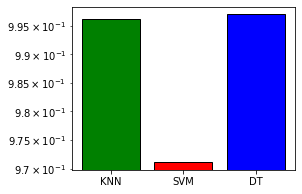

In [37]:
dict_accuracy = {'KNN' : accuracy_knn,
                 'SVM' : accuracy_svm,
                 'DT'  : accuracy_dt
                }

fig, ax = plt.subplots(figsize=(4, 3))

ax.bar(dict_accuracy.keys(), dict_accuracy.values(), color=['green', 'red', 'blue'], edgecolor='k')
ax.set_yscale('log')


# 9. Reduzindo Dimensões com PCA

In [38]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
df = pd.read_csv('firewall_log.csv')
df = balancear_dataset(df)
le = LabelEncoder()
df = df.apply(le.fit_transform)
X  = df.values
Y  = df['Action'].values
df.drop('Action', axis=1, inplace=True)
norm      = StandardScaler()
X_norm    = norm.fit_transform(X)

### Como definir a quantidade de componentes?

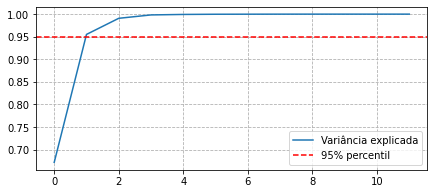

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7, 3))
pca = PCA().fit(X)
ax.plot(np.cumsum(pca.explained_variance_ratio_), label='Variância explicada')
ax.axhline(0.95, color='red', linestyle='--', label='95% percentil')
ax.grid(True, linestyle='--')
plt.legend()

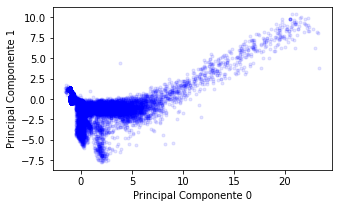

In [40]:
from sklearn.decomposition import PCA
pca       = PCA(n_components=2)
dados_pca = pca.fit_transform(X_norm)

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(dados_pca[:, 0], dados_pca[:, 1], marker='.', color='b', alpha=0.1)
ax.set_xlabel('Principal Componente 0')
ax.set_ylabel('Principal Componente 1');

# 10. Visualizando Regiões de Decisão

In [41]:
!pip install mlxtend


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### separando dados treino e teste

In [42]:
classes = le.fit_transform(Y)
x_treino, x_teste, y_treino, y_teste = train_test_split(dados_pca, classes, test_size=0.2, random_state=99)

### Treinando classificadores

In [43]:
knn     = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_treino, y_treino)

svm = SVC(kernel='linear')
svm.fit(x_treino, y_treino)

dt = DecisionTreeClassifier()
dt.fit(x_treino, y_treino)

DecisionTreeClassifier()

### Plotando regiões de Decisão

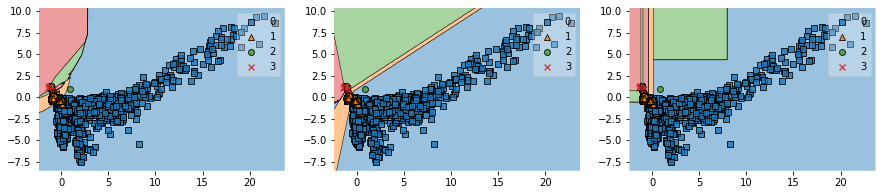

In [44]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_decision_regions(x_teste, y_teste, clf=knn, ax=ax[0]);
plot_decision_regions(x_teste, y_teste, clf=svm, ax=ax[1]);
plot_decision_regions(x_teste, y_teste, clf=dt, ax=ax[2]);